In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
cd gdrive/"My Drive"/Dataset/

/content/gdrive/My Drive/Dataset


In [3]:
import string
import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History    ###################################
from keras.optimizers import Adam
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from pickle import dump
from pickle import load
from os import listdir
import os
import sys


In [4]:
def progressBar(value, endvalue, bar_length=20,job='Job'):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [5]:
def load_doc(filename):
  file = open(filename,'r')
  text = file.read()
  file.close()
  return text

# Loads image_id from train/dev/test dataset
#contains only image_id
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  for line in doc.split("\n"):
    #excludes empty lines
    if len(line)<1:
      continue
    #removes the .jpg extension
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

#loads the description for train/test/ dev set
# By matching image_id from token.txt
def load_description(doc):
  #empty dict
  mapping = dict()  
  #split by line
  #each line contains image_id and desc of image
  for line in doc.split("\n"):
    #if len of line is less than 2 skip that line
    if(len(line)<2):
      continue
    #split by space
    token = line.split()
    image_id, image_desc = token[0], token[1:]
    #remove the .jpg#0 extension
    image_id = image_id.split(".")[0]
    #converts desc back to string
    image_desc = ' '.join(image_desc)

    if image_id not in mapping:
      mapping[image_id] = list()
    #if id present as key the append desc as list
    mapping[image_id].append(image_desc)
  return mapping

In [6]:
# remove puctuation from dataset
# converts to lower case
def clean_descriptions(description):
  table = str.maketrans('', '', string.punctuation) 
  for key, desc_list in description.items():
    for i in range(len(desc_list)):
      line = desc_list[i]
      desc = line.split()
      desc = [word.lower() for word in desc]
      desc = [word.translate(table) for word in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      desc_list[i] = ' '.join(desc)

# add starting and end tag
def load_clean_descriptions(filename,dataset):
  doc = load_doc(filename)
  description = dict()
  for line in doc.split('\n'):
    token = line.split()
    image_id, image_desc = token[0], token[1:]
    if image_id in dataset:
      if image_id not in description:
        description[image_id] = list()
      image_desc = 'startseq ' +' '.join(image_desc) + ' endseq'
      description[image_id].append(image_desc)
  return description

In [7]:
#loads all image_id and descriptions
doc = load_doc("Flickr8k.token.txt")
description = load_description(doc)
print("Length Of Description: ",len(description))

clean_descriptions(description)

train = load_set("Flickr_8k.trainImages.txt")
print("Train Dataset Length:",len(train))
test = load_set("Flickr_8k.testImages.txt")
print("Test Dataset Length:",len(test))
dev = load_set("Flickr_8k.devImages.txt")
print("Test Dataset Length:",len(dev))

train_descriptions = load_clean_descriptions('description.txt',train)
test_descriptions = load_clean_descriptions('description.txt',test)
dev_descriptions = load_clean_descriptions('description.txt',dev)

Length Of Description:  8092
Train Dataset Length: 6000
Test Dataset Length: 1000
Test Dataset Length: 1000


In [9]:
#save the description to new file, one line per desc
def save_description(description, filename):
  lines = list()
  for key, desc_list in description.items():
    [lines.append(key + ' ' + desc) for desc in desc_list]
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_description(description, 'description.txt')

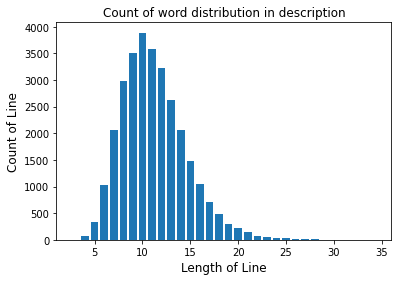

In [8]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
def plot_data(description):
  mapper=dict()
  for key, desc in description.items():
    for line in desc:
      length = len(re.findall(r'\w+', line))
      mapper[length] = mapper.get(length,0) + 1 
  plot_bar(mapper)

def plot_bar(mapper):
  plt.bar(mapper.keys(), mapper.values())
  plt.xlabel('Length of Line', fontsize=12)
  plt.ylabel('Count of Line', fontsize=12)
  plt.title('Count of word distribution in description')
  plt.show()

plot_data(train_descriptions)
#for length, count in mapper.items():
#  print(length, count)

#res = list(description.keys())[0]
#print(description['1000268201_693b08cb0e'])

In [9]:
#build a vocabulary from description
def to_vocabulary(description, word_count_threshold):
  all_captions = []
  for key, value in description.items():
    [all_captions.append(line) for line in value]
  
  #count only words that occurs more than word_count_threshold
  word_count = {}
  for line in all_captions:
    for word in line.split():
      word_count[word] = word_count.get(word,0) + 1
  vocab = [w for w in word_count if word_count[w] >= word_count_threshold]
  #plot_bar(word_count)
  return vocab
  
vocab = to_vocabulary(train_descriptions, 5)
print("Vocabulary Size:",len(vocab))
sorted(vocab)[:10]

Vocabulary Size: 2530


['about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action',
 'adult',
 'adults',
 'advertisement']

In [10]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(vocab)
#save the tokenizer to file
# so we don't have to load entire flicker8k_dataset
#dump(tokenizer,open('tokenizer.pkl','wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 2532


In [11]:
wordtoix = {}
ixtoword = {}

#no word in vocab has index 0, but padding will have index 0
tokenizer.word_index['PAD0'] = 0 
wordtoix = tokenizer.word_index
for word in tokenizer.word_index:
  ixtoword[tokenizer.word_index[word]] = word

print(len(ixtoword), len(wordtoix))

2532 2532


In [12]:
def max_length(description, p):
	#lines = to_lines(descriptions)
	#return max(len(d.split()) for d in lines)
  all_desc = []
  #create a list of all desc
  for key, desc in description.items():
    [all_desc.append(line) for line in desc]
  length = list(len(line.split()) for line in all_desc)
  print('{} percentile has len of lines less than: {}'.format(p,np.percentile(length, p)))
  print('longest sentence: ', max(length))
  return int(np.percentile(length, p))

 
max_length = max_length(train_descriptions,90)
print("Max Length for training:",max_length)

90 percentile has len of lines less than: 16.0
longest sentence:  34
Max Length for training: 16


In [13]:
#only keep sentences in desc that has all words from vocab
def trim_rare_sentences(desc):
  num_desc = 0
  num_trim = 0
  new_desc = desc.copy()
  for key in new_desc:
    new_desc[key] = []
  
  #filter out pairs for trimmed words
  i = 0
  for key in desc:
    i += 1
    progressBar(value=i, endvalue=len(desc))
    for line in desc[key]:
      num_desc += 1
      keep_input = True
      for word in line.split():
        if word not in vocab:
          keep_input = False
          break
      #only keep desc that do not contains trimmed words
      if keep_input:
        num_trim += 1
        new_desc[key].append(line)
    
  print("Trimmed from {} pairs to {}".format(num_desc, num_trim))
  return new_desc

final_train_desc = trim_rare_sentences(train_descriptions)
#dump(tokenizer,open('final_train_desc.pkl','wb'))
print("length:",len(final_train_desc))  

Job Completion: [------------------->] 100%Trimmed from 30000 pairs to 23274
length: 6000


In [13]:
final_train_desc = load(open('final_train_desc.pkl', 'rb'))

In [14]:
model = InceptionV3(weights='imagenet')
model = Model(model.input, model.layers[-2].output)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
def extract_features(directory):
  features = dict()
  for name in listdir(directory):
    filename = directory + '/' + name
    image = load_img(filename, target_size=(299,299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    # = np.reshape(image, image.shape[1])
    feature = model.predict(image,verbose=0)
    image_id = name.split('.')[0]
    features[image_id] = feature
    print('>%s' % name)
  return features

directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features:',len(features))
#save the features to file
#dump(features,open('features.pkl','wb'))

In [16]:
#Loads image and corresponding pre-trained features
def load_photo_features(filename, dataset):
  all_features = load(open(filename, 'rb'))
  features = {k : all_features[k] for k in dataset}
  return features

train_features = load_photo_features('features.pkl', train)
print('Photos:',len(train_features))
test_features = load_photo_features('features.pkl',test)
print('Photos:',len(test_features))
dev_features = load_photo_features('features.pkl',dev)
print('Photos:',len(dev_features))

#dump(train_features,open('train_features.pkl','wb'))
#dump(test_features,open('test_features.pkl','wb'))
#dump(dev_features,open('dev_features.pkl','wb'))

Photos: 6000
Photos: 1000
Photos: 1000


In [15]:
#def create_sequence(tokenizer, max_length, desc_list, photo, vocab_size):
#  X1, X2, y = list(), list(), list()
#  for desc in desc_list:
#    seq = tokenizer.texts_to_sequences([desc])[0]
#    for i in range(1, len(seq)):
      # split input output seq pair
      # at begining 'startseq' partial caption is i/p seq
      # to predict 1st wrd
#      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
#      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#      X1.append(photo)
#      X2.append(in_seq)
#      y.append(out_seq)
#  return np.array(X1), np.array(X2), np.array(y)

#def data_generator(description, photos, tokenizer, max_length, vocab_size):
#  while 1:
#    for key, desc_list in description.items():
      #photo = photos[key][0]
#      photo = photos[key]
      #in_img, in_seq, out_word = create_sequence(tokenizer, max_length, desc_list, photo, vocab_size)
      #yield ([in_img, in_seq], out_word)

In [17]:
# outputs a batch of captions-pictures
batch_size = 32
def data_generator(descriptions, photos):
  X1, X2, y = [], [], []
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n+=1
      # retrieve the photo feature
      photo = photos[key][0]
      for desc in desc_list:
        # find the index of each word of the caption in vocabulary
        seq = tokenizer.texts_to_sequences(desc.split())
        # split one sequence into multiple X, y pairs
        # Each step of the following for loop selects one word
        # from the caption, consider that word as y and
        # all the words before that will be the X
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
      # yield the batch data
      if n == batch_size:
        yield ([np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1))
        X1, X2, y = list(), list(), list()
        n=0

In [18]:
# test the data generator
generator = data_generator(train_descriptions, train_features)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(1754, 2048)
(1754, 16)
(1754,)


In [19]:
#pretrained Glove-embedding: 6B tokens, 100d vectors, 400K vocab uncased
#trained on wikipedia dataset 2014 and gigaword 5
def make_embedding_layer(embedding_dim):
  glove_dir = 'glove'
  embeddings_index = {}
  file = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
  f = file.read()
  for line in f.split('\n'):
    if len(line)<1:
      continue
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    file.close()
    # Get x-dim dense vector for each of the vocab_rocc
    embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
    for word, i in wordtoix.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
  print('GloVe loaded!')

  embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
  embedding_layer.build((None,))
  embedding_layer.set_weights([embedding_matrix])
  
  return embedding_layer

In [20]:
# in order to make model faster, I load embd outside the make_model
#embedding_layer = make_embedding_layer(100)
#dump(embedding_layer,open('embedding.pkl','wb'))
embedding_layer = load(open('embedding.pkl', 'rb'))


In [21]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [36]:
def define_model(embedding, vocab_size, max_length):
  # feature extractor model
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # sequence model
  inputs2 = Input(shape=(max_length,))
  #se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se1 = embedding(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  #decoder model
  decoder1 = add([fe2,se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1,inputs2],outputs=outputs)
  #model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, clipvalue=5), metrics='accuracy')
  model.compile(loss=masked_loss_function, optimizer= Adam(clipvalue=3))
  model.summary()
  plot_model(model, to_file='model.png', show_layer_names=True ,show_shapes=True)
  return model


In [37]:
model = define_model(embedding_layer, vocab_size, max_length)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 100)      253200      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_6[0][0]                    
_______________________________________________________________________________________

In [24]:
history={'loss':[], 'BLEU_val':[]}

In [25]:
my_callbacks = [
    EarlyStopping(monitor='loss', patience=2),
    ReduceLROnPlateau(monitor='loss', factor=0.9, patience=3, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
    #ModelCheckpoint(filepath='model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    #ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.2, min_lr=1e-6),
   # keras.callbacks.TensorBoard(log_dir='./logs')
]


In [26]:
# generate a description for an image
# Greedy approach
def generate_desc(model, photo):
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    #seq = tokenizer.texts_to_sequences([in_text])[0]
    seq = tokenizer.texts_to_sequences(in_text.split())
    # pad input
    #seq = pad_sequences([seq], maxlen=max_length)
    photo = photo.reshape((1,2048))
    seq = pad_sequences([seq], maxlen=max_length).reshape((1,max_length))
    # predict next word
    yhat = model.predict([photo,seq], verbose=0)
    #convert probability to integer
    yhat = np.argmax(yhat)
    # map integer to word
    word = ixtoword[yhat]
    if word is None:
      break
    # append as input for generating the next word
    in_text += ' ' + word
    # stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text

In [27]:
# heuristic search, finds k best sentences
def beam_search(model, photo, wordtoix, k_beams):
  start = [wordtoix['startseq']]
  start_word = [[start,0.0]]
  while len(start_word) < max_length:
    temp = []
    for s in start_word:
      #sequence of most probable words 
      # based on the previous steps
      sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) 
      preds = model.predict([photo.reshape(1,2048), sequence])
      # sort predictions based on the probability  
      # then take the last K_beams items, words with the most probs
      word_preds = np.argsort(preds[0])[-k_beams:] 
      # Getting the top <K_beams>(n) predictions and creating a 
      # new list so as to put them via the model again
      for w in word_preds:
        next_cap, prob = s[0][:], s[1]
        next_cap.append(w)
        prob += preds[0][w]
        temp.append([next_cap, prob])
    start_word = temp
    # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
    # Getting the top words
    start_word = start_word[-k_beams:]

  start_word = start_word[-1][0]
  captions_ = [ixtoword[i] for i in start_word]
  final_caption = []
  for i in captions_:
    if i != end_token:
      final_caption.append(i)
    else:
      break

  final_caption = ' '.join(final_caption[1:])
  return final_caption

In [28]:
#evaluate the efficiency of the model on test set
def evaluate_model(model, description, photos, k_beams):
  actual, predicted = list(), list()
  # step over the whole set
  i=0
  for key, desc_list in description.items():
    i += 1
    progressBar(i, len(description), bar_length=20,job='Evaluating')
    if k_beams == 1:
      yhat = generate_desc(model, photos[key])
    else:
      yhat = beam_search(model, photos[key], wordtoix, k_beams=k_beams)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
    b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  print('\n')
  #score for 1-gram model
  print('BLEU-1: %f' % b1)
  #50% score calculated on 1-gram and other 50% using 2-gram
  print('BLEU-2: %f' % b2)
  #33% to each 1,2 and 3 gram
  print('BLEU-3: %f' % b3)
  # 1/4 score of each gram
  print('BLEU-4: %f' % b4)
  return [b1,b2,b3,b4]
 

====


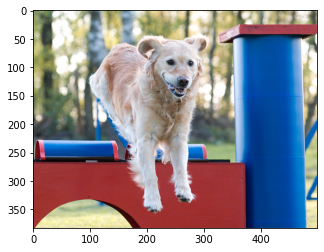

Greedy: startseq batman batman fencing tricycle tricycle batman tricycle batman tricycle tricycle batman tricycle tricycle candle tricycle batman


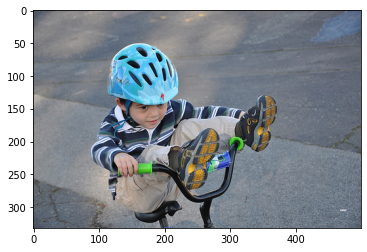

Greedy: startseq pigtails splashing pigtails splashing pigtails splashing teenage teenage teenage teenage gym together crown crown together together


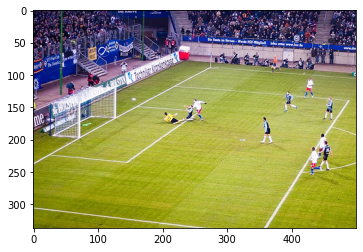

Greedy: startseq pigtails outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor outdoor


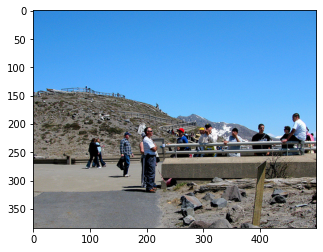

Greedy: startseq creating creating pigtails creating smokes creating pigtails creating smokes creating smokes creating creating smokes creating smokes
====


In [29]:
def test(i=5,j=20,k=50,q=850,show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    #print("Actual:",test_descriptions[pic][0])
    #print("Actual:",test_descriptions[pic][1])
    
    pic = list(test_features.keys())[j]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    
    pic = list(test_features.keys())[k]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    pic = list(test_features.keys())[q]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))

    print('====')
    
    
test(show_pic=True)

In [30]:
tf.config.run_functions_eagerly(True)

In [38]:
# Training for more than 30 epoch may lead to overfitting
epochs = 31
batch_size = 32
steps = len(train_descriptions)//batch_size
ep = 1
for i in range(ep,epochs):
  print('Epoch :',i,'\n')
  generator = data_generator(train_descriptions, train_features)
  #fit for one epoch
  h = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=my_callbacks)
  history['loss'].append(h.history['loss'])
  if i%3 == 0:
    model.save('new_model_' + str(i) + '.h5')
  
  if i%6 == 0:
    test()
    belus= evaluate_model(model, dev_descriptions, dev_features, k_beams=1)
    history['BLEU_val'].append((belus,i))
    print('\n','='*80)

dump(history,open('history.pkl','wb'))

Epoch : 1 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


187/187 [==============================] - 27s 145ms/step - loss: 5.0244
Epoch : 2 

187/187 [==============================] - 27s 144ms/step - loss: 4.0821
Epoch : 3 

187/187 [==============================] - 28s 147ms/step - loss: 3.7454
Epoch : 4 

187/187 [==============================] - 28s 148ms/step - loss: 3.5464
Epoch : 5 

187/187 [==============================] - 27s 146ms/step - loss: 3.4093
Epoch : 6 

187/187 [==============================] - 27s 146ms/step - loss: 3.3087
====
Greedy: startseq dog is jumping over the grass endseq
Greedy: startseq boy in red shirt and red shirt is riding bike endseq
Greedy: startseq boy in red shirt is playing with ball in the air endseq
Greedy: startseq group of people are walking on the edge of the ocean endseq
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.585989
BLEU-2: 0.351485
BLEU-3: 0.256535
BLEU-4: 0.135032

Epoch : 7 

187/187 [==============================] - 27s 147ms/step - loss: 3.2259
Epoch : 8 



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Evaluating Completion: [>                   ] 0%

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Evaluating Completion: [------------------->] 100%

BLEU-1: 0.564354
BLEU-2: 0.337362
BLEU-3: 0.245886
BLEU-4: 0.125595

Epoch : 13 

187/187 [==============================] - 28s 148ms/step - loss: 2.9007
Epoch : 14 

187/187 [==============================] - 27s 145ms/step - loss: 2.8662
Epoch : 15 

187/187 [==============================] - 27s 145ms/step - loss: 2.8329
Epoch : 16 

187/187 [==============================] - 27s 146ms/step - loss: 2.8026
Epoch : 17 

187/187 [==============================] - 27s 146ms/step - loss: 2.7777
Epoch : 18 

187/187 [==============================] - 27s 145ms/step - loss: 2.7494
====
Greedy: startseq dog runs through the grass endseq
Greedy: startseq man in red shirt is sitting on the street endseq
Greedy: startseq three boys play soccer endseq
Greedy: startseq group of people are standing on top of rocks overlooking the mountains endseq
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.568550
BLEU-2: 0.337279
BLEU-3: 

In [39]:
model.save_weights('weights.h5')

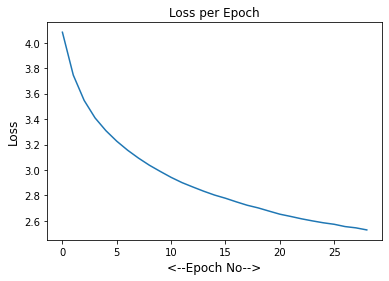

In [85]:
#plotting the loss during various epochs
y = []
y = [item for sublist in history['loss'] for item in sublist]
x = [i for i in range(len(history['loss']))]
plt.xlabel('<--Epoch No-->', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss per Epoch')
plt.plot(x,y)

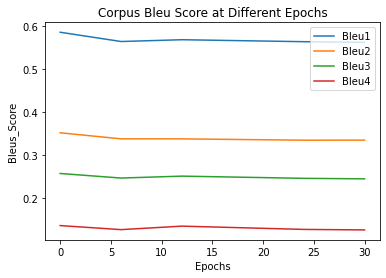

In [157]:
y = []
y = [item for sublist in history['BLEU_val'] for item in sublist]
y = y[::2]
y1 = [item for sublist in y for item in sublist]
bleu_val1 = y1[::4]
bleu_val2 = y1[1::4]
bleu_val3 = y1[2::4]
bleu_val4 = y1[3::4]

x = [0,6,12,24,30]
plt.plot(x, bleu_val1, label = "Bleu1")
plt.plot(x, bleu_val2, label = "Bleu2")
plt.plot(x, bleu_val3, label = "Bleu3")
plt.plot(x, bleu_val4, label = "Bleu4")
plt.xlabel('Epochs')
plt.ylabel('Bleus_Score')
plt.title('Corpus Bleu Score at Different Epochs')
plt.legend()
plt.show()

In [33]:
#model = load_model('new_model_25.h5')

In [34]:
#evaluating test data with beam width 1(greedy)
evaluate_model(model, test_descriptions, test_features, k_beams=1)

Evaluating Completion: [>                   ] 0%

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Evaluating Completion: [------------------->] 100%

BLEU-1: 0.550675
BLEU-2: 0.330217
BLEU-3: 0.243853
BLEU-4: 0.127783


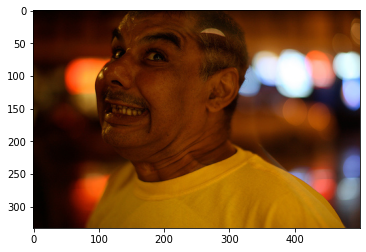

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Greedy: startseq man with shaved hair and beard is smiling endseq
Beam k=3: startseq man in yellow shirt is smiling endseq 
	 startseq man standing on road wearing yellow shirt endseq 
	 startseq person is enjoying with short hair endseq


In [41]:
pic = list(test_features.keys())[560]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, feature))
print("Beam K= 3:",beam_search(model, test_features[pic], wordtoix, k_beams = 3))

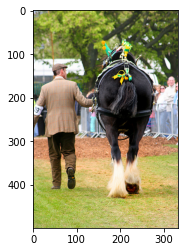

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "



Greedy: startseq two horses pull sled endseq
Beam k=3: startseq black horse is walking down the field endseq 
	 startseq person is walking beside the horse endseq 
	 startseq horse is riding on grass endseq


In [46]:
pic = list(test_features.keys())[340]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("\nGreedy:",generate_desc(model, feature))
print("Beam K= 3:",beam_search(model, test_features[pic], wordtoix, k_beams = 3))

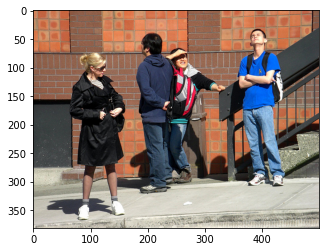

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "



Greedy: startseq man in black shirt and jeans is standing in front of crowd of people endseq
Beam k=3: startseq women wearing black coat standing on street endseq 
	 startseq group of people are standing beside stairs endseq 
	 startseq boy in blue shirt and blue jeans is standing down the road endseq


In [45]:
pic = list(test_features.keys())[905]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("\nGreedy:",generate_desc(model, feature))
print("Beam K= 3:",beam_search(model, test_features[pic], wordtoix, k_beams = 3))

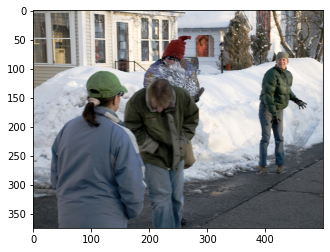

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "



Greedy: startseq man in red jacket stands in front of snow endseq
Beam k=3: startseq two boys are playing in snow endseq 
	 startseq man in green jacket skating in snow endseq 
	 startseq people are playing in snow endseq


In [48]:
pic = list(test_features.keys())[725]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("\nGreedy:",generate_desc(model, feature))
print("Beam K= 3:",beam_search(model, test_features[pic], wordtoix, k_beams = 3))

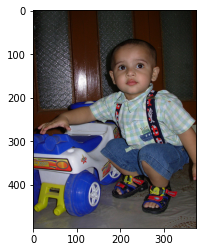

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "



Greedy: startseq little boy is playing with toy toy endseq


In [158]:
pic = list(test_features.keys())[11]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("\nGreedy:",generate_desc(model, feature))

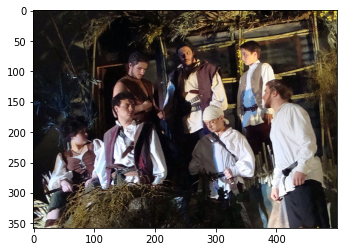

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "



Greedy: startseq group of people are taking picture of an audience endseq


In [160]:
pic = list(test_features.keys())[186]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("\nGreedy:",generate_desc(model, feature))